In [6]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import pandas as pd
import numpy as np
from skimage.transform import resize

%matplotlib inline

random_state = 31418

#img_name = '../../ISIC-2017_Training_Data/ISIC_0003056.jpg'
img_name = '../../ISIC-2017_Training_Data/ISIC_0000056.jpg'
#img_name = '../../ISIC-2017_Training_Data/ISIC_0013341.jpg'

def load_img(img_name):
    orig_img = imread(img_name)
    scale =  250.0/orig_img.shape[0]
    resize_v = round(scale * orig_img.shape[0])
    resize_h = round(scale * orig_img.shape[1]/3)*3

    img_small = resize(orig_img, (resize_v, resize_h), preserve_range=True).astype(np.uint8)
    
    return img_small

In [7]:
from scipy import ndimage
from skimage.filters.rank import median
from skimage.morphology import disk, black_tophat

def hair_removal(I):
    mask = disk(30)
    img_blurry = I.copy()
    img_blurry[:,:,0] = median(I[:,:,0], mask)
    img_blurry[:,:,1] = median(I[:,:,1], mask)
    img_blurry[:,:,2] = median(I[:,:,2], mask)

    selem = disk(10)
    closed = black_tophat(np.mean(I,2),  selem)

    img_nohair = I.copy()
    val = 40
    img_nohair[closed>val] = img_blurry[closed>val]
    return img_nohair

#img = hair_removal(img_small)

In [8]:
import skfuzzy
from skimage.util.shape import view_as_blocks

def segment_image(n_objects, I):
    features = np.zeros((I.shape[0], I.shape[1], I.shape[2]+2))
    max_dim = float(np.amax(I.shape[0:2]))
    x = np.linspace(0, I.shape[1]/max_dim, I.shape[1])
    y = np.linspace(0, I.shape[0]/max_dim, I.shape[0])
    xv, yv = np.meshgrid(x, y)

    features[:, :, 0:3] = I
    features[:, :, 3] = xv*100
    features[:, :, 4] = yv*100

    fet_vec = features.reshape((features.shape[0]*features.shape[1], features.shape[2]))
    fet_vec.shape
    
    cntr, u, u0, d, jm, p, fpc = skfuzzy.cluster.cmeans(data=fet_vec.T, c=n_objects, 
                                     m=2, error=0.01, maxiter=1000, seed=random_state)
    return (cntr, u)


def get_clusters_imgs(n_objects, I, threshold):
    cntr = []
    memberships = []

    #Break into blocks
    blk_shape = (I.shape[0]/2,I.shape[1]/3, 3)
    Blocks = view_as_blocks(I, blk_shape)

    # Segment each blcok
    for index in np.ndindex(Blocks.shape[0], Blocks.shape[1], Blocks.shape[2]):
        print (index)
        cur_cntr, cur_memberships = segment_image(6, Blocks[index])
        cntr.append(cur_cntr)
        memberships.append(cur_memberships)

    # Create cluster images
    # Each "group" is cluster i for all blocks. In the end we have n_objects * num_blocks clusters
    group_imgs = []
    cluster_idx = 0

    for group in range(n_objects):
        cur_group = np.zeros((I.shape[0], I.shape[1]))
        cur_group_block = view_as_blocks(cur_group, blk_shape[0:2])

        cur_block = 0
        for block_idx in np.ndindex(Blocks.shape[0], Blocks.shape[1]):
            blk = np.zeros(blk_shape[0]*blk_shape[1])

            blk[memberships[cur_block][group] > threshold] = cluster_idx + 1
            cur_group_block[block_idx] = blk.reshape(blk_shape[0:2])
            cluster_idx += 1
            cur_block += 1

        group_imgs.append(cur_group)

    return group_imgs

#n_objects = 5
#group_imgs = get_clusters_imgs(n_objects, img, 0.2)

In [16]:
from colorsys import hls_to_rgb

def get_distinct_colors(n):
    colors = []

    for i in np.arange(0., 360., 360. / n):
        h = i / 360.
        l = (50 + np.random.rand() * 10) / 100.
        s = (90 + np.random.rand() * 10) / 100.
        colors.append(hls_to_rgb(h, l, s))

    return colors

def visualize_clusters(group_imgs):
    clusters = np.zeros(group_imgs[0].shape)
    clusters_flat = clusters.ravel()

    for i in range(len(group_imgs)):
        flat_gi = group_imgs[i].ravel()
        clusters_flat[flat_gi > 0] = flat_gi[flat_gi > 0]
    
    colors = np.array(get_distinct_colors(len(np.unique(clusters))))
    #plt.imshow(colors[clusters.astype(int)])
    

    return colors[clusters.astype(int)]

ISIC_0000000: 0/2000
(0, 0, 0)
(0, 1, 0)
(0, 2, 0)
(1, 0, 0)
(1, 1, 0)
(1, 2, 0)
ISIC_0000001: 1/2000
(0, 0, 0)
(0, 1, 0)


KeyboardInterrupt: 

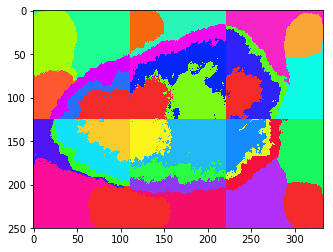

In [15]:
import glob, re, os, warnings
from skimage.io import imsave

start_at = 0
end_at = 25
n_objects = 5
out_dir = './out'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)


num_processed = 0
for file_name in sorted(glob.glob('../../ISIC-2017_Training_Data/*.jpg')):
    if num_processed < start_at:
        num_processed += 1
        continue
        
    img_name = re.match(r'.*/(ISIC_\d+)\.jpg', file_name).group(1)
    print ("%s: %d/%d" % (img_name, num_processed, 2000))

    img_small = load_img(file_name)
    img = hair_removal(img_small)
    group_imgs = get_clusters_imgs(n_objects, img, 0.2)
    visual_clusters = visualize_clusters(group_imgs)
    
    # Save Images
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i in range(len(group_imgs)):
            imsave(('%s/%s_%d.png' % (out_dir, img_name, i)), group_imgs[i].astype(int))
            
        imsave(('%s/%s_visual.gif' % (out_dir, img_name)), visual_clusters)
    
    num_processed += 1
    
    if num_processed > end_at:
        break

# import glob, re, os, warnings
# from skimage.io import imsave

# start_at = 0
# end_at = 25
# n_objects = 5
# out_dir = './out'
# if not os.path.exists(out_dir):
#     os.makedirs(out_dir)


# num_processed = 0
# for file_name in sorted(glob.glob('../../ISIC-2017_Training_Data/*.jpg')):
#     if num_processed < start_at:
#         num_processed += 1
#         continue
        
#     img_name = re.match(r'.*/(ISIC_\d+)\.jpg', file_name).group(1)
#     print ("%s: %d/%d" % (img_name, num_processed, 2000))

#     img_small = load_img(file_name)
#     img = hair_removal(img_small)
#     group_imgs = get_clusters_imgs(n_objects, img, 0.2)
#     visual_clusters = visualize_clusters(group_imgs)
    
#     # Save Images
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         for i in range(len(group_imgs)):
#             imsave(('%s/%s_%d.png' % (out_dir, img_name, i)), group_imgs[i].astype(int))
            
#         imsave(('%s/%s_visual.gif' % (out_dir, img_name)), visual_clusters)
    
#     num_processed += 1
    
#     if num_processed > end_at:
#         break